In [1]:
from PIL import Image, ImageDraw
import numpy as np
import statsmodels.api as sm
import pandas as pd
import json
import math
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
from matplotlib import pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data_dir_base = '/root/data/blender_v3'
idx = 0

def get_data(data_dir_base, idx, include_image=True):
    # get annotation data
    annotation_file_name = 'annot_{}.json'.format(idx)
    annotation_file_path = '{}/{}/{}'.format(data_dir_base, 'annotations', annotation_file_name)
    annotation_data = json.load(open(annotation_file_path, 'rb'))

    # get segmentation data
    segmentation_file_name = 'left_{}.npy'.format(idx)
    segmentation_file_path = '{}/{}/{}'.format(data_dir_base, 'mask', segmentation_file_name)
    mask = np.load(segmentation_file_path)

    # get depth map data
    depth_map_file_name = 'depth_map_{}.npy'.format(idx)
    depth_map_file_path = '{}/{}/{}'.format(data_dir_base, 'depth_map', depth_map_file_name)
    depth_map = np.load(depth_map_file_path).T
    
    # get image
    data = { 'annotation_data': annotation_data, 'mask': mask, 'depth_map': depth_map }
    if include_image:
        image_file_name = 'left_{}.png'.format(idx)
        image_file_path = '{}/{}/{}'.format(data_dir_base, 'stereo_images', image_file_name)
        image = Image.open(image_file_path)
        data['image'] = image
        
    return data
    
    



In [3]:
data = get_data(data_dir_base, idx)
annotation_data = data['annotation_data']
image = data['image']
mask = data['mask']
blender_depth_map = data['depth_map']*10 # the multiplication by 10 is to convert from dm to cm

<h1> Apply projection to get orthogonal depth map from Blender depth map </h1>

In [4]:
focal_length = 1.0
baseline = 6.5
image_sensor_width = 3.2
image_sensor_height = 1.8
px_count_width = mask.shape[1]
px_count_height = mask.shape[0]


In [15]:
def get_world_point_cloud(blender_depth_map, focal_length):
    
    px_count_width = blender_depth_map.shape[1]
    px_count_height = blender_depth_map.shape[0]
    
    image_center_x = int(px_count_width / 2)
    image_center_y = int(px_count_height / 2)

    a = np.tile(np.array(range(blender_depth_map.shape[1])), [blender_depth_map.shape[0], 1])
    b = px_count_height - 1 - np.tile(np.array(range(blender_depth_map.shape[0])), [blender_depth_map.shape[1], 1]).T
    pixel_array = np.dstack([b, a]) - np.array([image_center_y, image_center_x])
    sensor_array = pixel_array * np.array([(image_sensor_height / px_count_height), (image_sensor_width / px_count_width)])

    world_y = blender_depth_map / np.sqrt(1 + (sensor_array[:,:,0]**2 + sensor_array[:,:,1]**2) / (focal_length**2))
    world_x = (sensor_array[:,:,1] * world_y) / focal_length
    world_z = (sensor_array[:,:,0] * world_y) / focal_length
    world_point_cloud = np.dstack([world_x, world_y, world_z])
    
    return world_point_cloud


In [16]:
get_world_point_cloud(blender_depth_map, focal_length)

3.2 1.8


array([[[-119.16781769,   74.47988606,   66.85733522],
        [-119.17071866,   74.59825894,   66.96359338],
        [-119.17363156,   74.71701038,   67.07019135],
        ..., 
        [ 106.11618372,   66.63496623,   59.81529391],
        [ 106.11382526,   66.52904405,   59.7202122 ],
        [ 106.11146842,   66.42345441,   59.625429  ]],

       [[-119.16141271,   74.47588294,   66.67918895],
        [-119.16430833,   74.59424621,   66.78516106],
        [-119.16720913,   74.71298378,   66.89146829],
        ..., 
        [ 106.11055657,   66.6314327 ,   59.65595459],
        [ 106.10821157,   66.5255245 ,   59.56113365],
        [ 106.10586869,   66.4199491 ,   59.46661068]],

       [[-119.1550252 ,   74.47189075,   66.50107119],
        [-119.15790788,   74.59023967,   66.60675308],
        [-119.1608036 ,   74.70896777,   66.71277357],
        ..., 
        [ 106.1049457 ,   66.62790939,   59.49664096],
        [ 106.10260712,   66.52201074,   59.40207677],
        [ 106.10026

In [10]:
wpc

array([[[-119.16781769,   74.47988606,   66.85733522],
        [-119.17071866,   74.59825894,   66.96359338],
        [-119.17363156,   74.71701038,   67.07019135],
        ..., 
        [ 106.11618372,   66.63496623,   59.81529391],
        [ 106.11382526,   66.52904405,   59.7202122 ],
        [ 106.11146842,   66.42345441,   59.625429  ]],

       [[-119.16141271,   74.47588294,   66.67918895],
        [-119.16430833,   74.59424621,   66.78516106],
        [-119.16720913,   74.71298378,   66.89146829],
        ..., 
        [ 106.11055657,   66.6314327 ,   59.65595459],
        [ 106.10821157,   66.5255245 ,   59.56113365],
        [ 106.10586869,   66.4199491 ,   59.46661068]],

       [[-119.1550252 ,   74.47189075,   66.50107119],
        [-119.15790788,   74.59023967,   66.60675308],
        [-119.1608036 ,   74.70896777,   66.71277357],
        ..., 
        [ 106.1049457 ,   66.62790939,   59.49664096],
        [ 106.10260712,   66.52201074,   59.40207677],
        [ 106.10026

In [203]:
wpc

array([[[-119.16781769,   74.47988606,   66.85733522],
        [-119.17071866,   74.59825894,   66.96359338],
        [-119.17363156,   74.71701038,   67.07019135],
        ..., 
        [ 106.11618372,   66.63496623,   59.81529391],
        [ 106.11382526,   66.52904405,   59.7202122 ],
        [ 106.11146842,   66.42345441,   59.625429  ]],

       [[-119.16141271,   74.47588294,   66.67918895],
        [-119.16430833,   74.59424621,   66.78516106],
        [-119.16720913,   74.71298378,   66.89146829],
        ..., 
        [ 106.11055657,   66.6314327 ,   59.65595459],
        [ 106.10821157,   66.5255245 ,   59.56113365],
        [ 106.10586869,   66.4199491 ,   59.46661068]],

       [[-119.1550252 ,   74.47189075,   66.50107119],
        [-119.15790788,   74.59023967,   66.60675308],
        [-119.1608036 ,   74.70896777,   66.71277357],
        ..., 
        [ 106.1049457 ,   66.62790939,   59.49664096],
        [ 106.10260712,   66.52201074,   59.40207677],
        [ 106.10026

In [189]:
annotation_data

{'sensor_height': 3.2,
 'unit_system': 'METRIC',
 'volume': 4410.102564548064,
 'focal_length': 1.0,
 'sensor_width': 1.8,
 'length': 103.80229591233405,
 'interocular_distance': 0.6499999761581421,
 'unit': 'centimeter',
 'width': 17.300382652055674,
 'height': 20.76045918246681}

<h1> Get depth distribution across all points on the visible surface of the fish </h1>

In [190]:
hist_counts, hist_bucket_endpoints = np.histogram(depth_map[np.where(mask > 0)], 20)
print(hist_bucket_endpoints)
print(hist_counts)
cutoff_idx = np.argmin(hist_counts)
cutoff = hist_bucket_endpoints[cutoff_idx]
print(cutoff_idx, cutoff)
print('Mean depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask > 0)) ].mean()))
print('Maximum depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask > 0)) ].max()))
print('Minimum depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask > 0)) ].min()))

[  41.32473983   46.71117903   52.09761822   57.48405741   62.87049661
   68.2569358    73.643375     79.02981419   84.41625338   89.80269258
   95.18913177  100.57557096  105.96201016  111.34844935  116.73488855
  122.12132774  127.50776693  132.89420613  138.28064532  143.66708451
  149.05352371]
[5240 5669 4001 3381 2450 2083 1734 1205  483  389  489  248  362  379    0
    0    0    0    0   69]
14 116.734888545
Mean depth value: 60.6394547159633
Maximum depth value: 116.02112691206054
Minimum depth value: 41.3247398337992


<h1> Get pixel coordinates for determining length, width, and breadth </h1>

Consider the line $l$ (in pixel space) that best fits the pixels corresponding to the fish mask $M$ according to a least-squares regression. Let $p_1 \in M$ be the point on line $l$ with the smallest $x$-coordinate, and let $p_2 \in M$ be the point on $l$ with the largest $x$-coordinate. The line segment defined by these two points corresponds to the length of the fish in pixel space. 

Now consider centroid $c = (\bar{x}, \bar{y})$ of the fish mask and the line $k$ that passes through $c$ and is perpendicular to $l$. 

In [191]:
def get_points_of_interest(mask, cutoff):
    mask_values = np.where(mask > 0)
    x_values = mask_values[1]
    y_values = mask_values[0]
    adj_y_values = mask.shape[0] - y_values
    mask_points = list(zip(x_values, adj_y_values))

    A = np.vstack([x_values, np.ones(len(x_values))]).T
    res = np.linalg.lstsq(A,adj_y_values)
    m, b = res[0]

    # get length endpoints
    x_lower = x_values.min()
    while x_lower < mask.shape[1]:
        adj_y_lower = int(round(m*x_lower + b))
        y_lower = mask.shape[0] - 1 - adj_y_lower
        if ((x_lower, adj_y_lower) in mask_points and (depth_map[y_lower, x_lower] < cutoff)): 
            break
        x_lower += 1

    x_upper = x_values.max()
    while x_upper > 0:
        adj_y_upper = int(round(m*x_upper + b))
        y_upper = mask.shape[0] - 1 - adj_y_upper
        if ((x_upper, adj_y_upper) in mask_points and (depth_map[y_upper, x_upper] < cutoff)):
            break
        x_upper -= 1

    y_lower = mask.shape[0] - 1 - adj_y_lower
    y_upper = mask.shape[0] - 1 - adj_y_upper
    length_endpoint_1 = (x_lower, y_lower)
    length_endpoint_2 = (x_upper, y_upper)

    # get width endpoints
    m = -1 / float(m)
    b = adj_y_values.mean() - m*x_values.mean()

    adj_y_lower = adj_y_values.min()
    while adj_y_lower < mask.shape[0]:
        x_lower = int(round((adj_y_lower - b)/float(m)))
        y_lower = mask.shape[0] - 1 - adj_y_lower
        if ((x_lower, adj_y_lower) in mask_points and (depth_map[y_lower, x_lower] < cutoff)):
            break
        adj_y_lower += 1


    adj_y_upper = adj_y_values.max()
    while adj_y_upper > 0:
        x_upper = int(round((adj_y_upper - b)/float(m)))
        y_upper = mask.shape[0] - 1 - adj_y_upper
        if ((x_upper, adj_y_upper) in mask_points and (depth_map[y_upper, x_upper] < cutoff)):
            break
        adj_y_upper -= 1

    # y_lower = mask.shape[0] - 1 - adj_y_lower
    # y_upper = mask.shape[0] - 1 - adj_y_upper
    width_endpoint_1 = (x_lower, y_lower)
    width_endpoint_2 = (x_upper, y_upper)

    # get centroid coordinates
    x_visible_centroid = mask_values[1].mean()
    y_visible_centroid = mask_values[0].mean()
    visible_centroid = (x_visible_centroid, y_visible_centroid)
    return {
        'length_endpoint_1': length_endpoint_1,
        'length_endpoint_2': length_endpoint_2,
        'width_endpoint_1': width_endpoint_1,
        'width_endpoint_2': width_endpoint_2,
        'visible_centroid': visible_centroid
    }

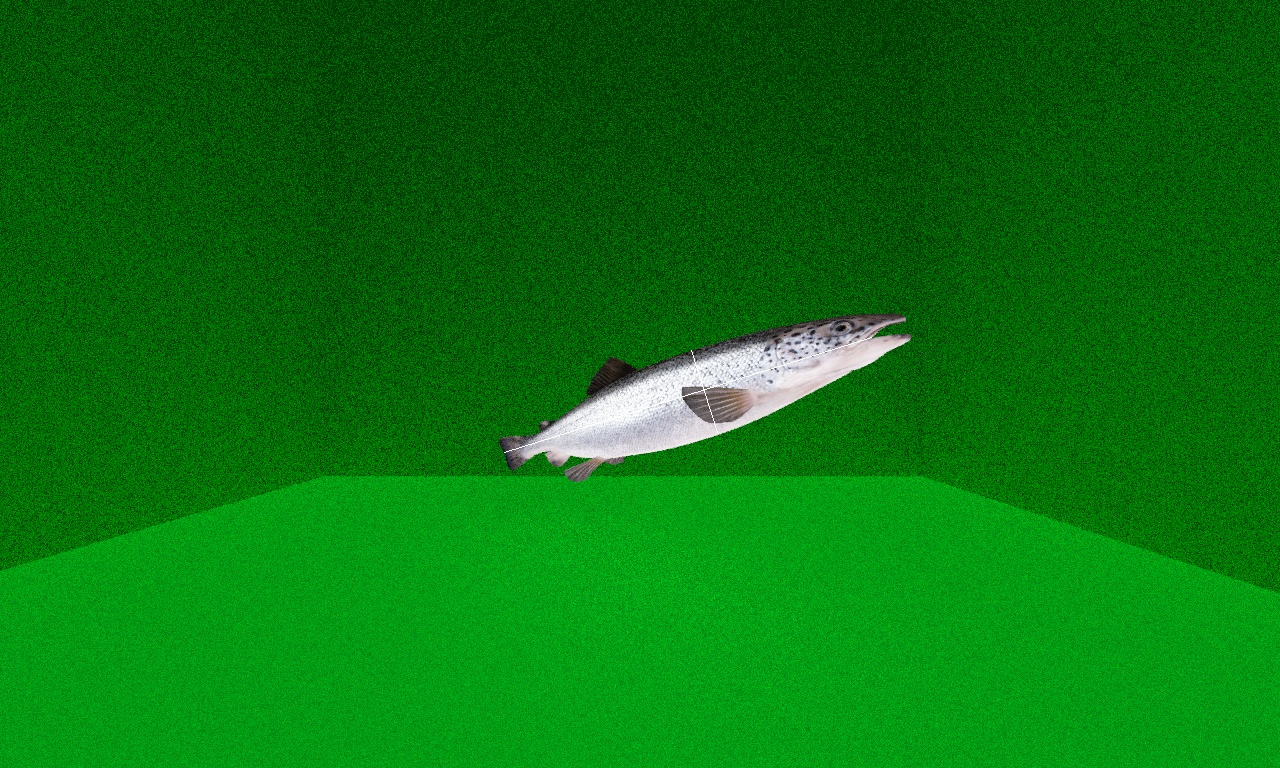

In [192]:
results = get_points_of_interest(mask, cutoff)
length_endpoint_1 = results['length_endpoint_1']
length_endpoint_2 = results['length_endpoint_2']
width_endpoint_1 = results['width_endpoint_1']
width_endpoint_2 = results['width_endpoint_2']
visible_centroid = results['visible_centroid']
draw = ImageDraw.Draw(image)
draw.line((length_endpoint_1[0], length_endpoint_1[1], length_endpoint_2[0], length_endpoint_2[1]), fill=255)
draw.line((width_endpoint_1[0], width_endpoint_1[1], width_endpoint_2[0], width_endpoint_2[1]), fill=255)
image

<h1> Get length and width in world space </h1>

In [193]:
def convert_to_world_point(x, y, depth_map):
    image_center_x = depth_map.shape[1] / 2.0
    image_center_y = depth_map.shape[0] / 2.0
    px_x = x - image_center_x
    px_z = image_center_y - y
    sensor_x = px_x * (image_sensor_width / px_count_width)
    sensor_z = px_z * (image_sensor_height / px_count_height)

    d = depth_map[y, x]
    world_y = d
    world_x = (world_y * sensor_x) / focal_length
    world_z = (world_y * sensor_z) / focal_length
    
    return (world_x, world_y, world_z)

def distance_between_points(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def distance_between_points_2d(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [194]:
length_endpoint_1_world = convert_to_world_point(length_endpoint_1[0], length_endpoint_1[1], depth_map)
length_endpoint_2_world = convert_to_world_point(length_endpoint_2[0], length_endpoint_2[1], depth_map)
width_endpoint_1_world = convert_to_world_point(width_endpoint_1[0], width_endpoint_1[1], depth_map)
width_endpoint_2_world = convert_to_world_point(width_endpoint_2[0], width_endpoint_2[1], depth_map)
visible_centroid_world = convert_to_world_point(int(round(visible_centroid[0])), int(round(visible_centroid[1])), depth_map)
length = distance_between_points(length_endpoint_1_world, length_endpoint_2_world)
width = distance_between_points(width_endpoint_1_world, width_endpoint_2_world)

In [197]:
length_endpoint_1

(504, 452)

In [200]:

depth_map[length_endpoint_1[1], length_endpoint_1[0]]

115.18649702414564

In [198]:
length_endpoint_1_world

(-39.163408988209518, 115.18649702414564, -18.357847963223211)

In [177]:
wpc[length_endpoint_1[1], length_endpoint_1[0]]

array([ -39.15049997,  115.14852934,  -18.62167623])

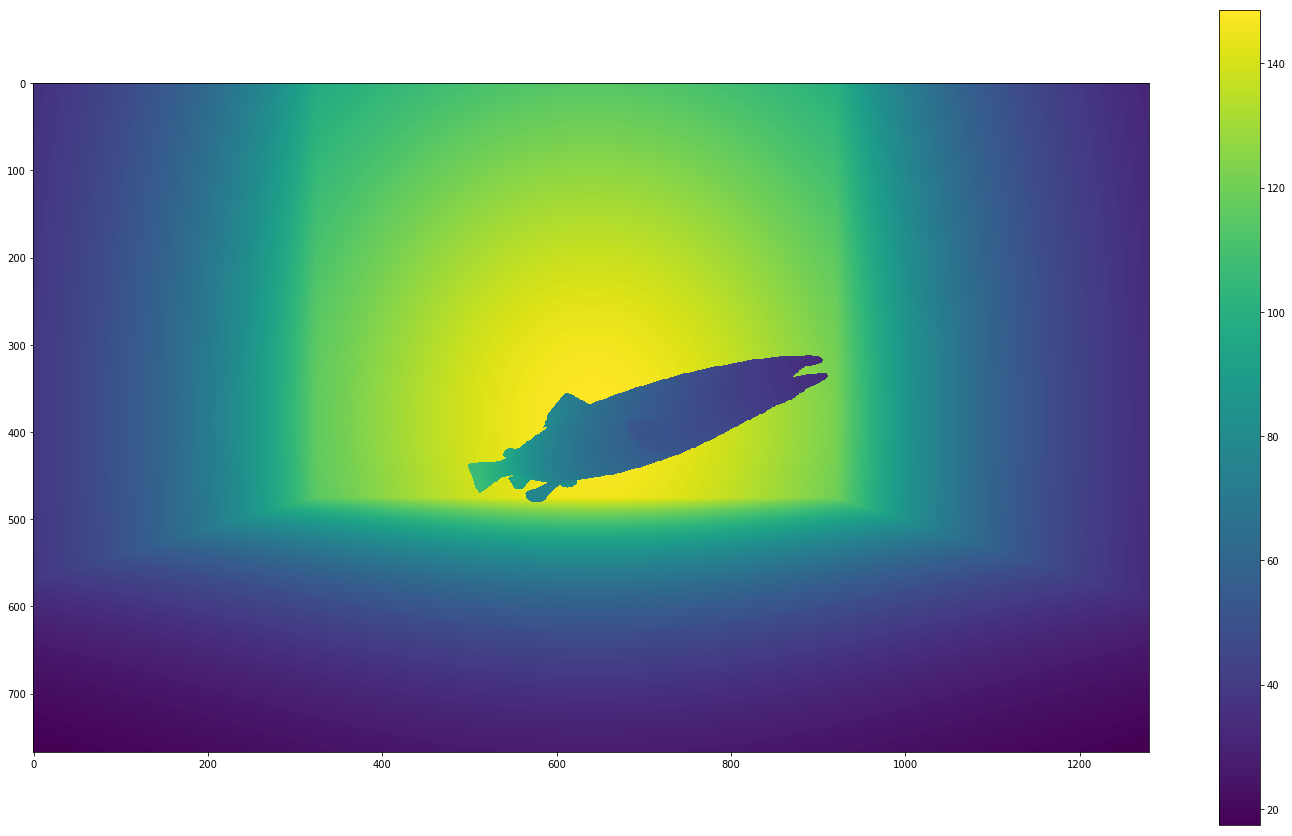

In [146]:
plt.figure(figsize=(25, 15))
plt.imshow(wpc[:,:,1])
plt.colorbar()

<h1> Extract features for all fish in the Blender dataset </h1>

In [119]:
data_dir_base = '/root/data/blender_v3'
COMPLETE_SAMPLE_SIZE = 4007
df = pd.DataFrame()
for idx in range(COMPLETE_SAMPLE_SIZE):
    
    print(idx)
    data = get_data(data_dir_base, idx, include_image=False)
    annotation_data = data['annotation_data']
    mask = data['mask']
    blender_depth_map = data['depth_map']*10
    depth_map = get_orthogonal_depth_map(blender_depth_map, focal_length)
    

    hist_counts, hist_bucket_endpoints = np.histogram(depth_map[np.where(mask > 0)], 20)
    cutoff_idx = np.argmin(hist_counts)
    cutoff = hist_bucket_endpoints[cutoff_idx]
    
    
    results = get_points_of_interest(mask, cutoff)
    length_endpoint_1 = results['length_endpoint_1']
    length_endpoint_2 = results['length_endpoint_2']
    width_endpoint_1 = results['width_endpoint_1']
    width_endpoint_2 = results['width_endpoint_2']
    visible_centroid = results['visible_centroid']
    
    # get length and width
    length_endpoint_1_world = convert_to_world_point(length_endpoint_1[0], length_endpoint_1[1], depth_map)
    length_endpoint_2_world = convert_to_world_point(length_endpoint_2[0], length_endpoint_2[1], depth_map)
    width_endpoint_1_world = convert_to_world_point(width_endpoint_1[0], width_endpoint_1[1], depth_map)
    width_endpoint_2_world = convert_to_world_point(width_endpoint_2[0], width_endpoint_2[1], depth_map)
    visible_centroid_world = convert_to_world_point(int(round(visible_centroid[0])), int(round(visible_centroid[1])), depth_map)
    length = distance_between_points(length_endpoint_1_world, length_endpoint_2_world)
    width = distance_between_points(width_endpoint_1_world, width_endpoint_2_world)
    
    # get breadth
    alpha = distance_between_points_2d(visible_centroid, width_endpoint_1) / distance_between_points_2d(width_endpoint_2, width_endpoint_1)
    centroid = tuple(np.array(width_endpoint_1_world) + alpha * (np.array(width_endpoint_2_world) - np.array(width_endpoint_1_world)))
    breadth = 2 * distance_between_points(centroid, visible_centroid_world)
    
    ground_truth_length = annotation_data['length']
    ground_truth_width = annotation_data['height']
    ground_truth_breadth = annotation_data['width']

    line_to_append = { 
        'predicted_length': length, 
        'predicted_width': width,
        'predicted_breadth': breadth,
        'ground_truth_length': ground_truth_length,
        'ground_truth_width': ground_truth_width,
        'ground_truth_breadth': ground_truth_breadth
    }
    df = df.append(line_to_append, ignore_index=True)
    

0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [66]:
df

,ground_truth_breadth,ground_truth_length,ground_truth_width,predicted_breadth,predicted_length,predicted_width
0,17.300383,103.802296,20.760459,11.984033,98.418882,11.985132
1,17.941267,107.647604,21.529521,3.335287,103.202104,15.508471
2,18.334776,110.008658,22.001732,3.790914,106.185957,10.530140
3,15.266147,91.596881,18.319376,3.514089,88.043976,7.744522
4,15.612331,93.673988,18.734798,2.010243,92.221052,13.107320
5,13.967980,83.807878,16.761576,3.138486,82.832939,6.780608
6,17.121365,102.728189,20.545638,5.452132,98.175491,16.147550
7,18.217677,109.306060,21.861212,4.771153,107.535495,12.361873
8,19.351352,116.108112,23.221622,4.299156,111.246076,16.489323
9,9.982202,59.893212,11.978642,7.167884,56.729289,8.517295


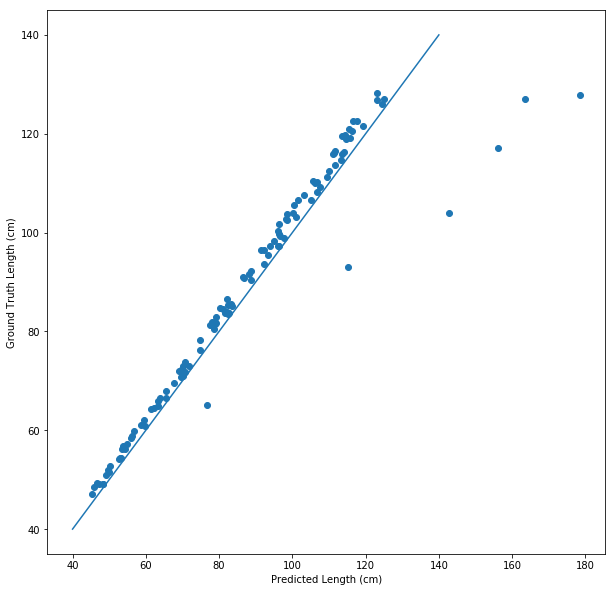

In [117]:
plt.figure(figsize=(10, 10))
plt.scatter(df.predicted_length, df.ground_truth_length)
plt.plot([40, 140], [40, 140])
plt.xlabel('Predicted Length (cm)')
plt.ylabel('Ground Truth Length (cm)')
plt.show()

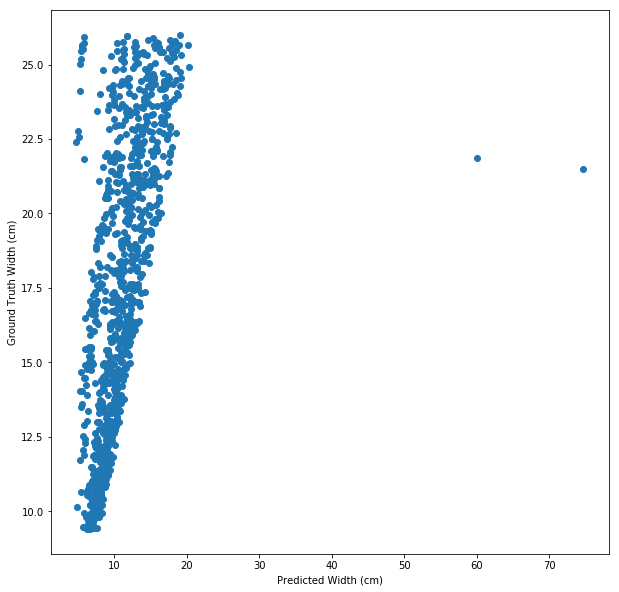

In [84]:
plt.figure(figsize=(10, 10))
plt.scatter(df.predicted_width, df.ground_truth_width)
# plt.plot([40, 140], [40, 140])
plt.xlabel('Predicted Width (cm)')
plt.ylabel('Ground Truth Width (cm)')
plt.show()

In [131]:
get_orthogonal_depth_map(depth_map, focal_length)

array([[ 35.61138179,  35.7006157 ,  35.79017308, ...,  31.94801623,
         31.86805775,  31.78838559],
       [ 35.62667458,  35.71597686,  35.80560094, ...,  31.96184386,
         31.88182645,  31.80209581],
       [ 35.64195087,  35.7313192 ,  35.82101204, ...,  31.97565694,
         31.89557852,  31.81578514],
       ..., 
       [ 17.46175719,  17.47819892,  17.49465961, ...,  17.52684693,
         17.51034617,  17.49386875],
       [ 17.40866879,  17.4250465 ,  17.44144417, ...,  17.47350152,
         17.45706621,  17.44065195],
       [ 17.35584943,  17.37216042,  17.38849564, ...,  17.42042478,
         17.40405326,  17.38770268]])